# Модель ARIMA
 
Данная модель типа ARIMA прогнозирует месячную цену биткоина.
- Парметры модели подобраны исходя из минимальности как информационного критеррия Акаике (${AIC}=2k-2\ln(L)$), так и байесовскиго информационного критерия.
- Датасет содержит данные цены (включая цену открытия, закрытия, самую высокую и низкую) за период с 31.12.2011 по 14.09.2020 c биржи _Bitstamp_.

In [23]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from tqdm import tqdm
from scipy.special import inv_boxcox

Populating the interactive namespace from numpy and matplotlib


## 1. Первичное преобразование данных

In [2]:
data = pd.read_csv('bitcoin_price_bitstamp.csv')
data.head()

,Unix_Timestamp,DateTime,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,12/31/2011 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325346600,12/31/2011 15:50:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
2,1325350740,12/31/2011 16:59:00,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
3,1325350800,12/31/2011 17:00:00,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
4,1325391360,01/01/2012 04:16:00,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000


In [3]:
data.shape

(3330541, 9)

Проверим, есть ли пропущенные значения?

In [4]:
data.isnull().values.any()

False

In [5]:
%%time
data['DateTime'] = pd.to_datetime(data['DateTime'])

CPU times: user 5min 1s, sys: 244 ms, total: 5min 1s
Wall time: 5min 2s


In [6]:
data['Date'] = data['DateTime'].apply(lambda x: x.date())
data['Time'] = data['DateTime'].apply(lambda x: x.time())

In [7]:
del data['Unix_Timestamp']

Сначала давайте ограничимся только месячным датафреймом. Создадим также годовой и дневной DataFram-ы.

In [36]:
data_day = data.drop_duplicates(subset='Date', keep='last')
data_day.set_index('DateTime', inplace=True)
data_month = data_day.resample('M').mean()
data_year = data_day.resample('Y').mean()
data_month.shape

(3178, 10)

In [51]:
data_month.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
DateTime,,,,,,,
2020-05-31,9257.978065,9265.926129,9250.305161,9258.634194,13.709257,128901.803239,9258.657795
2020-06-30,9480.667667,9484.250667,9475.533333,9479.943667,6.050690,57478.288522,9480.843991
2020-07-31,9597.711613,9600.324194,9595.377742,9598.165484,2.616281,26320.921022,9597.617860
2020-08-31,11645.428387,11651.862581,11641.276774,11647.617742,3.232458,37622.808740,11646.962862
2020-09-30,10496.972143,10500.030000,10492.572857,10496.149286,4.160847,43568.263304,10496.838789


In [52]:
data_month.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106 entries, 2011-12-31 to 2020-09-30
Freq: M
Data columns (total 7 columns):
Open                 106 non-null float64
High                 106 non-null float64
Low                  106 non-null float64
Close                106 non-null float64
Volume_(BTC)         106 non-null float64
Volume_(Currency)    106 non-null float64
Weighted_Price       106 non-null float64
dtypes: float64(7)
memory usage: 6.6 KB


In [ ]:
data_month.to_csv('bitcoin_price_month')
data_day.to_csv('bitcoin_price_day')

Поделим выборку на test и train.

In [147]:
train_size = 95
data_train_month = data_month.iloc[:train_size, :]
data_test_month = data_month.iloc[train_size:,:]

## 2. Визуальный анализ ряда

### Посмортим на дневной и годовой timeframe.

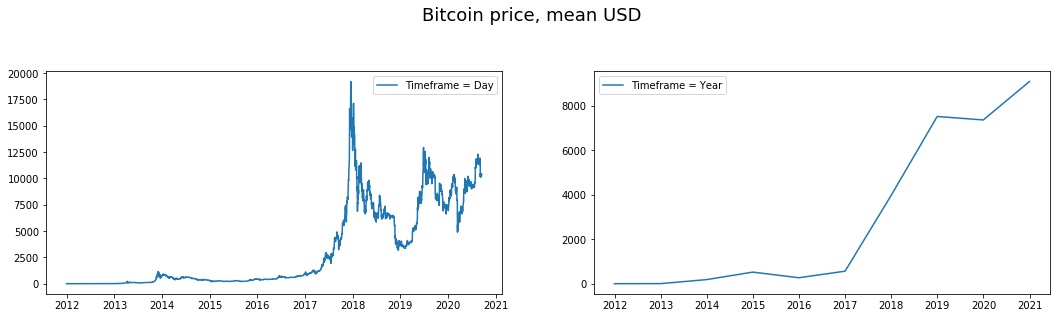

In [148]:
fig = plt.figure(figsize=(18, 9))
plt.suptitle('Bitcoin price, mean USD', fontsize=18)

plt.subplot(221)
plt.plot(data_day['Weighted_Price'], '-', label='Timeframe = Day')
plt.legend()


plt.subplot(222)
plt.plot(data_year['Weighted_Price'], label='Timeframe = Year')
plt.legend()

plt.show()

### Месячный timeframe.

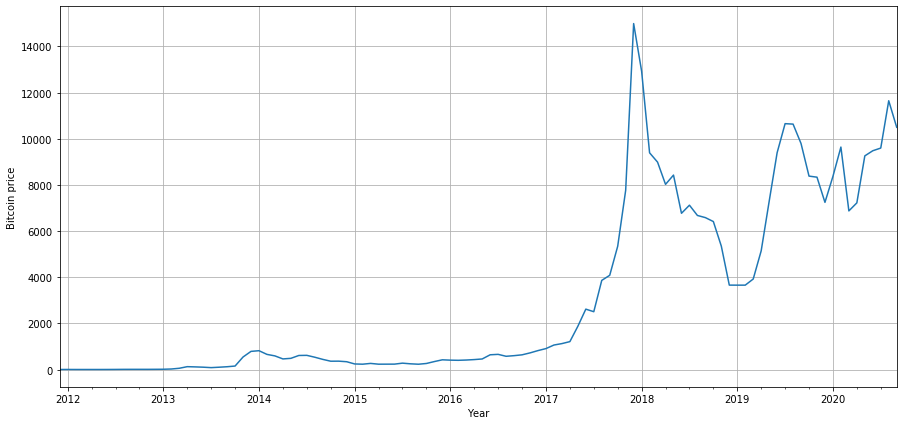

In [149]:
plt.figure(figsize(15, 7))
data_month['Weighted_Price'].plot()
plt.xlabel('Year')
plt.ylabel('Bitcoin price')
plt.grid()
plt.show()

Видно, что ряд нестационарен. Кроме того, у него есть явный восходящий тренд, нестационарная дисперсия. Убедимся в этом, проверив его на стационарность с помощью критерия Дики-Фуллера, а также проведем STL-декомпозицию ряда. 

Критерий Дики-Фуллера: p=0.432099


<Figure size 1080x720 with 0 Axes>

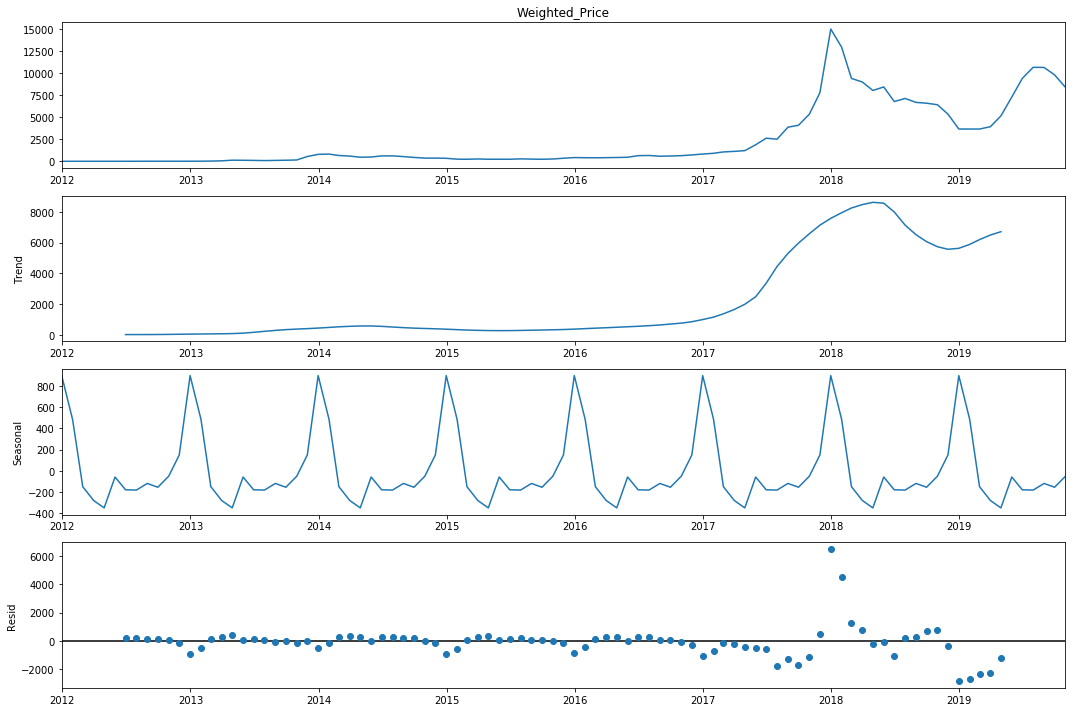

In [150]:
warnings.filterwarnings('ignore')
plt.figure(figsize(15,10))           
sm.tsa.seasonal_decompose(data_train_month['Weighted_Price']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_train_month['Weighted_Price'])[1])

Собственно, наши предположения подтверждаются. И дополнительно заметна выраженная сезонность.

## 3. Стабилизация дисперсии

Проведем стабилизацию дисперсии. Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр для преобразования Бокса-Кокса: 0.111548
Критерий Дики-Фуллера: p=0.656076


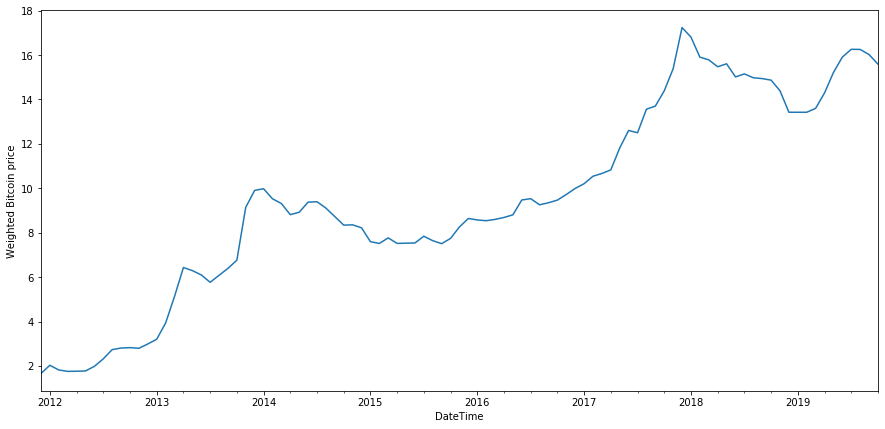

In [151]:
warnings.filterwarnings('ignore')
data_train_month['Weighted_Price_boxcox'], lmbda = stats.boxcox(data_train_month['Weighted_Price'])
plt.figure(figsize(15,7))
data_train_month['Weighted_Price_boxcox'].plot()
plt.ylabel(u'Weighted Bitcoin price')
print("Оптимальный параметр для преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_train_month['Weighted_Price_boxcox'])[1])

Видно, что дисперсия стала больше походить на стационарную, однако стационарным ряд все еще остался.

## 4. Выбор порядка дифференцирования

Критерий Дики-Фуллера подтверждает гипотезу нестационарности, да и визуально в данных виден тренд. Попробуем сезонное дифференцирование, а также сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.324756


<Figure size 1080x720 with 0 Axes>

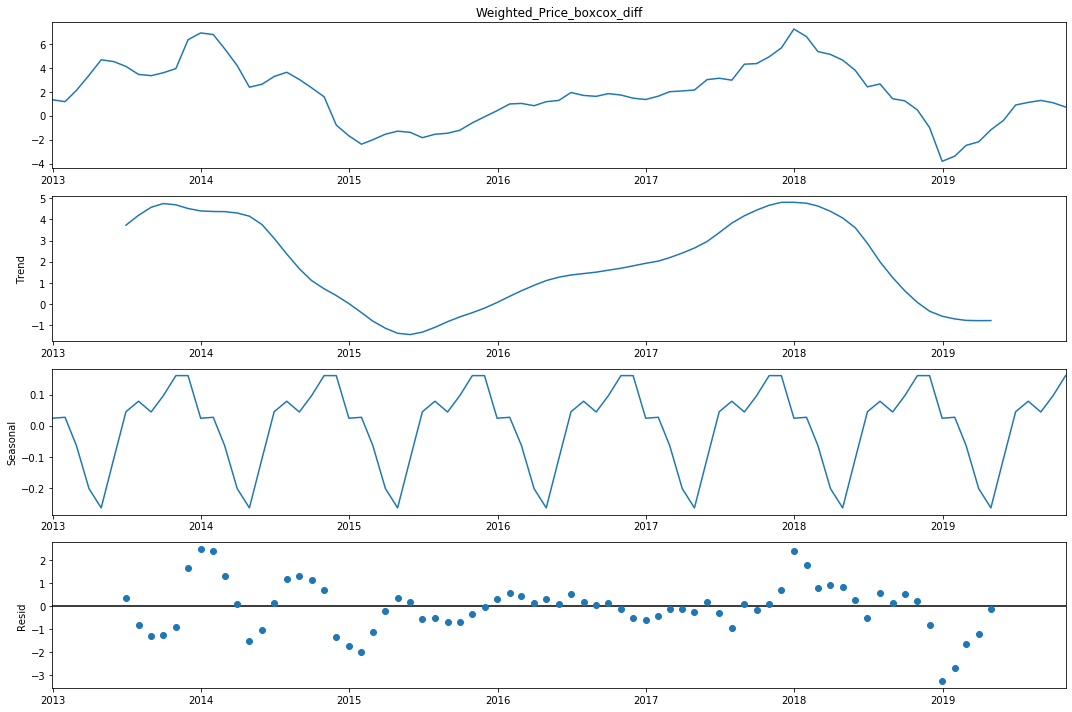

In [152]:
warnings.filterwarnings('ignore')
data_train_month['Weighted_Price_boxcox_diff'] = data_train_month['Weighted_Price_boxcox'] - data_train_month['Weighted_Price_boxcox'].shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data_train_month['Weighted_Price_boxcox_diff'].dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_train_month['Weighted_Price_boxcox_diff'] .dropna())[1])

Теперь критерий Дики-Фуллера отвергает гипотезу нестационарности, однако избавится от тренда все еще не удалось. Продифференцирем ряд с помощью обычного дифференцирования.

Критерий Дики-Фуллера: p=0.000002


<Figure size 1080x720 with 0 Axes>

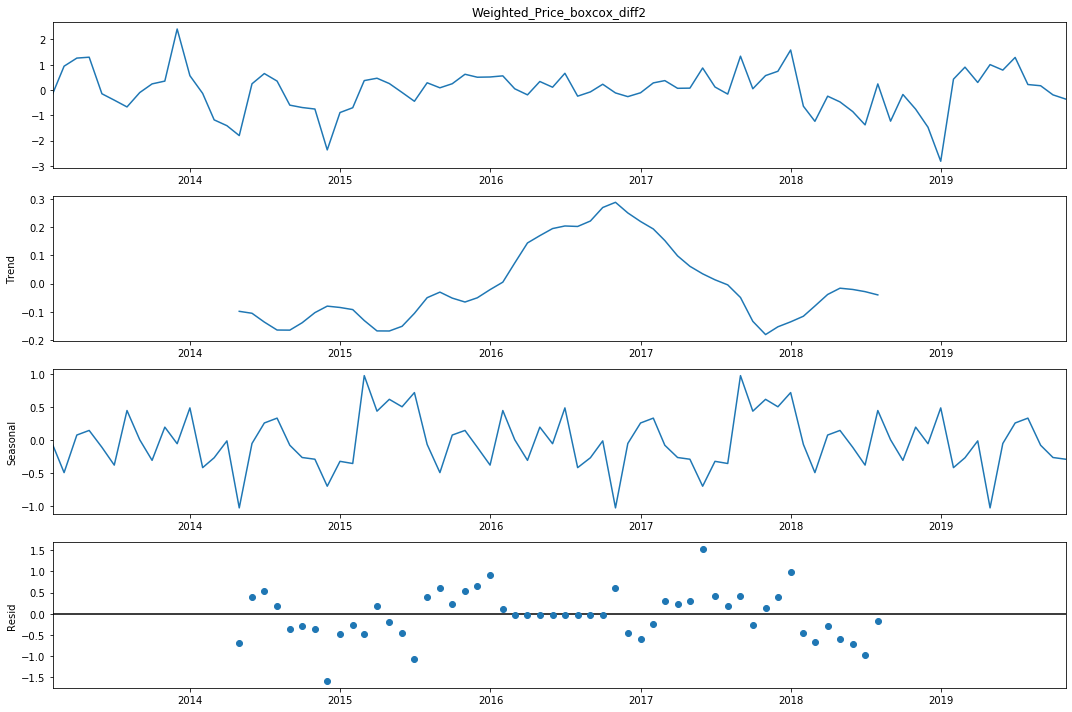

In [153]:
data_train_month['Weighted_Price_boxcox_diff2'] = data_train_month['Weighted_Price_boxcox_diff'] - data_train_month['Weighted_Price_boxcox_diff'].shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data_train_month['Weighted_Price_boxcox_diff2'].dropna(), freq=30).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_train_month['Weighted_Price_boxcox_diff2'].dropna())[1]);

Гипотеза нестационарности по критерияю Дики-Фуллера теперь явно отвергается, и визуально ряд выглядит лучше — преобладающего тренда больше нет. Значит, возьмём $D=1$ и $d=1$.

## 5. Выбор начальных приближений для $p, q, P, Q$

Для этого посмотрим на ACF и PACF полученного ряда:

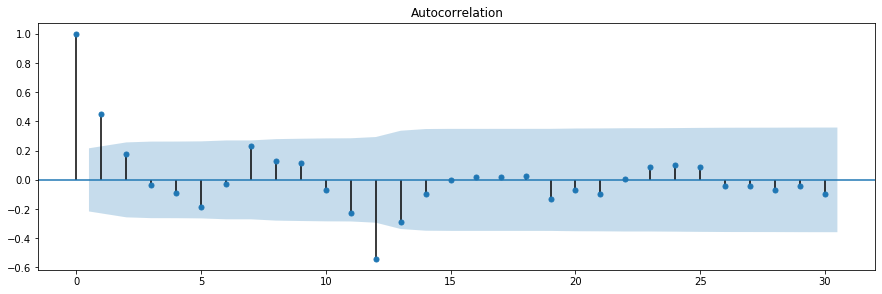

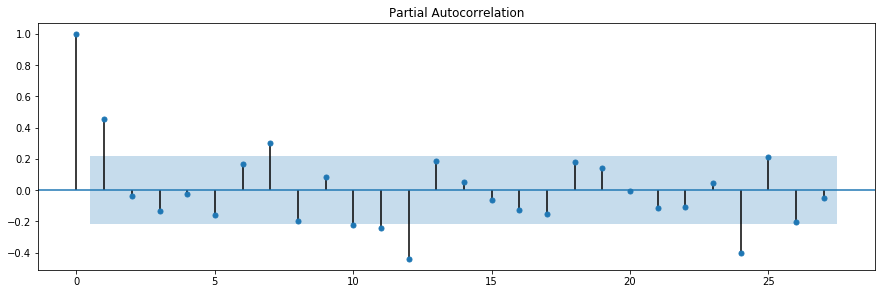

In [154]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(15,10))
ax = plt.subplot(211)
plot_acf(data_train_month['Weighted_Price_boxcox_diff2'].dropna().values.squeeze(),lags=30, ax=ax)
plt.show()
plt.figure(figsize=(15,10))
ax = plt.subplot(212)
plot_pacf(data_train_month['Weighted_Price_boxcox_diff2'].dropna().values.squeeze(), lags=27, ax=ax)
plt.show()

Возьмем начальные приближения $p=1, q=1, P=2, Q=1$ и переберем значения $p, q, P, Q$

In [163]:
ps = range(0, 4)
d = range(1,3)
qs = range(0, 4)
Ps = range(0, 4)
D = range(1,3)
Qs = range(0, 4)

In [164]:
parameters = product(ps, qs, Ps, Qs, d, D)
parameters_list = list(parameters)
print(len(parameters_list))
parameters_list

1024


[(0, 0, 0, 0, 1, 1),
 (0, 0, 0, 0, 1, 2),
 (0, 0, 0, 0, 2, 1),
 (0, 0, 0, 0, 2, 2),
 (0, 0, 0, 1, 1, 1),
 (0, 0, 0, 1, 1, 2),
 (0, 0, 0, 1, 2, 1),
 (0, 0, 0, 1, 2, 2),
 (0, 0, 0, 2, 1, 1),
 (0, 0, 0, 2, 1, 2),
 (0, 0, 0, 2, 2, 1),
 (0, 0, 0, 2, 2, 2),
 (0, 0, 0, 3, 1, 1),
 (0, 0, 0, 3, 1, 2),
 (0, 0, 0, 3, 2, 1),
 (0, 0, 0, 3, 2, 2),
 (0, 0, 1, 0, 1, 1),
 (0, 0, 1, 0, 1, 2),
 (0, 0, 1, 0, 2, 1),
 (0, 0, 1, 0, 2, 2),
 (0, 0, 1, 1, 1, 1),
 (0, 0, 1, 1, 1, 2),
 (0, 0, 1, 1, 2, 1),
 (0, 0, 1, 1, 2, 2),
 (0, 0, 1, 2, 1, 1),
 (0, 0, 1, 2, 1, 2),
 (0, 0, 1, 2, 2, 1),
 (0, 0, 1, 2, 2, 2),
 (0, 0, 1, 3, 1, 1),
 (0, 0, 1, 3, 1, 2),
 (0, 0, 1, 3, 2, 1),
 (0, 0, 1, 3, 2, 2),
 (0, 0, 2, 0, 1, 1),
 (0, 0, 2, 0, 1, 2),
 (0, 0, 2, 0, 2, 1),
 (0, 0, 2, 0, 2, 2),
 (0, 0, 2, 1, 1, 1),
 (0, 0, 2, 1, 1, 2),
 (0, 0, 2, 1, 2, 1),
 (0, 0, 2, 1, 2, 2),
 (0, 0, 2, 2, 1, 1),
 (0, 0, 2, 2, 1, 2),
 (0, 0, 2, 2, 2, 1),
 (0, 0, 2, 2, 2, 2),
 (0, 0, 2, 3, 1, 1),
 (0, 0, 2, 3, 1, 2),
 (0, 0, 2, 3, 2, 1),
 (0, 0, 2, 3,

## 6. Обучение и сравнение моделей-кандидатов

In [165]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for parametr in tqdm(parameters_list):
    
    try:
        model=sm.tsa.statespace.SARIMAX(data_train_month['Weighted_Price_boxcox'], order=(parametr[0], parametr[4], parametr[1]), 
                                        seasonal_order=(parametr[2], parametr[5], parametr[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('Wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_aic = aic
        best_model = model
        best_parametrs = parametr
    results.append([parametr, model.aic])

warnings.filterwarnings('default')

100%|██████████| 1024/1024 [1:12:37<00:00,  4.26s/it]

CPU times: user 3h 37min 40s, sys: 5h 34min 59s, total: 9h 12min 40s
Wall time: 1h 12min 37s


In [179]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print('Top-5 моделей:')
print(result_table.sort_values(by = 'aic', ascending=True).head())

Top-5 моделей:
             parameters         aic
264  (1, 0, 0, 2, 1, 1)  137.700427
276  (1, 0, 1, 1, 1, 1)  137.715467
304  (1, 0, 3, 0, 1, 1)  138.917531
968  (3, 3, 0, 2, 1, 1)  138.922065
72   (0, 1, 0, 2, 1, 1)  139.419067


Лучшая модель:

In [180]:
print(best_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                   Weighted_Price_boxcox   No. Observations:                   95
Model:             SARIMAX(1, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood                 -64.850
Date:                                 Tue, 17 Nov 2020   AIC                            137.700
Time:                                         23:05:01   BIC                            147.327
Sample:                                     12-31-2011   HQIC                           141.565
                                          - 10-31-2019                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3706      0.112      3.321      0.001       0.152       0

Отберем 30 лучших моделей и посмотрим на их значения байесовского информационного критерия.

In [197]:
%%time
best30_results = result_table.sort_values(by = 'aic', ascending=True).iloc[:30,:]
results_bic = []
best_bic = float("inf")
warnings.filterwarnings('ignore')

for i, raw_param in tqdm(enumerate(best30_results.iloc[:,0])):
    
    try:
        model=sm.tsa.statespace.SARIMAX(data_train_month['Weighted_Price_boxcox'], order=(raw_param[0], raw_param[4], raw_param[1]), 
                                        seasonal_order=(raw_param[2], raw_param[5], raw_param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('Wrong parameters:', param)
        continue
    bic = model.bic
    if bic < best_bic:
        best_bic = bic
        best_model_bic = model
        best_parametrs_bic = raw_param
    results_bic.append(model.bic)

warnings.filterwarnings('default')

30it [00:47,  1.58s/it]

CPU times: user 2min 22s, sys: 3min 43s, total: 6min 6s
Wall time: 47.5 s


In [201]:
best30_results.loc[:,'bic'] = results_bic
print(best30_results.head(10))

             parameters         aic         bic
264  (1, 0, 0, 2, 1, 1)  137.700427  147.327304
276  (1, 0, 1, 1, 1, 1)  137.715467  147.342344
304  (1, 0, 3, 0, 1, 1)  138.917531  150.951127
968  (3, 3, 0, 2, 1, 1)  138.922065  160.582538
72   (0, 1, 0, 2, 1, 1)  139.419067  149.045944
148  (0, 2, 1, 1, 1, 1)  139.522364  151.555960
136  (0, 2, 0, 2, 1, 1)  139.548331  151.581927
268  (1, 0, 0, 3, 1, 1)  139.640389  151.673985
280  (1, 0, 1, 2, 1, 1)  139.643599  151.677196
292  (1, 0, 2, 1, 1, 1)  139.676476  151.710072


В целом видно, что значения первая модель оптимальна и в смысле байесовского информационного критерия. Однако так как значения критерриев для топ-1 и топ-2 модели очень близки посмотрим и на прогнозы второй модели. И также на их усредненный прогноз.

In [202]:
best_model_2 = sm.tsa.statespace.SARIMAX(data_train_month['Weighted_Price_boxcox'], order=(best30_results.iloc[1,0][0], best30_results.iloc[1,0][4], best30_results.iloc[1,0][1]), 
                                        seasonal_order=(best30_results.iloc[1,0][2], best30_results.iloc[1,0][5], best30_results.iloc[1,0][3], 12)).fit(disp=-1)

## 7. Анализ остатков построенной модели (топ-1).
При необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения $p, q, P, Q$.

Критерий Стьюдента: p=0.712538
Критерий Дики-Фуллера: p=0.000000


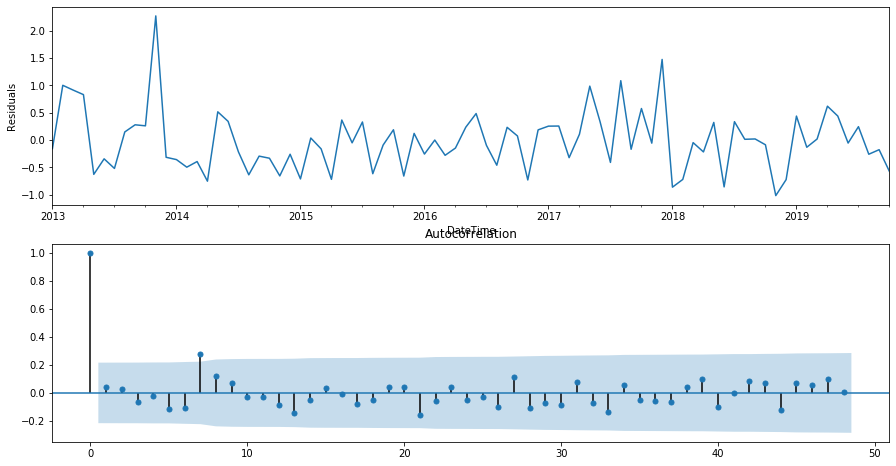

In [204]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (уверенно подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), в большинстве своем неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).

In [205]:
#критерий Льюнга-Бокса:
warnings.filterwarnings('ignore')
q_test = sm.tsa.stattools.acf(best_model.resid[13:], qstat=True)#qstat=True, означает что применяем указынный тест к коэф-ам
print('Процент остатков c p-value > 0.05: {}%'.format(np.mean(q_test[2]>0.05) * 100))
print(pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

Процент остатков c p-value > 0.05: 100.0%
       Q-stat   p-value
0    0.131286  0.717102
1    0.199607  0.905015
2    0.577015  0.901674
3    0.633613  0.959256
4    1.874807  0.866183
5    2.935798  0.816861
6   10.019266  0.187484
7   11.447208  0.177624
8   11.927190  0.217445
9   12.019920  0.283726
10  12.103109  0.355943
11  12.780256  0.385213
12  14.922271  0.312230
13  15.212781  0.363766
14  15.352666  0.426325
15  15.358197  0.498577
16  16.046420  0.520547
17  16.358565  0.567538
18  16.576130  0.618560
19  16.751178  0.669067
20  19.618276  0.545542
21  20.023975  0.581540
22  20.263481  0.625970
23  20.579809  0.663372
24  20.696396  0.709410
25  22.008405  0.688237
26  23.543054  0.655524
27  25.117788  0.621417
28  25.735391  0.639594
29  26.784637  0.634556
30  27.569976  0.643268
31  28.243335  0.657274
32  30.733387  0.580434
33  31.150960  0.608002
34  31.557147  0.635090
35  32.090784  0.655099
36  32.684862  0.671550
37  32.930802  0.702673
38  34.530009  0.67384

Посмотрим, насколько хорошо модель описывает данные:

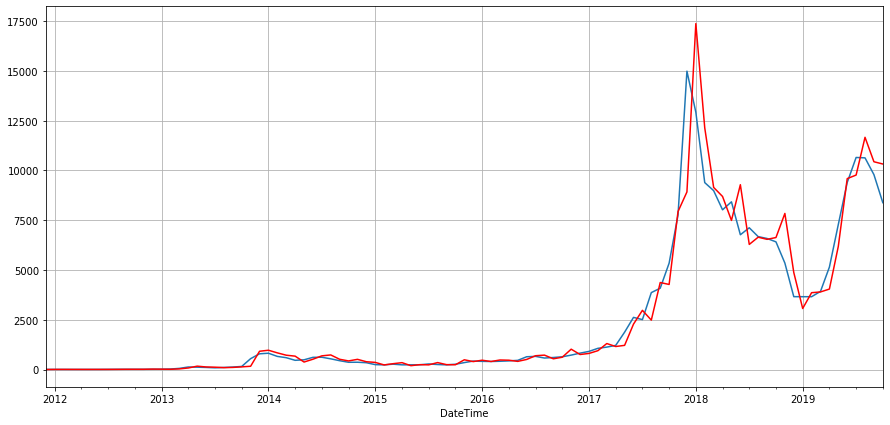

In [206]:
warnings.filterwarnings('ignore')

data_train_month['model'] = inv_boxcox(best_model.fittedvalues, lmbda)

plt.figure(figsize=(15, 7))
data_train_month['Weighted_Price'].plot()
data_train_month['model'].plot(color='r')
plt.grid()

Заметно, что модель достаточно близка к реальным данным.

## 8. Прогнозирование с помощью финальной модели (топ-1 и топ-2).

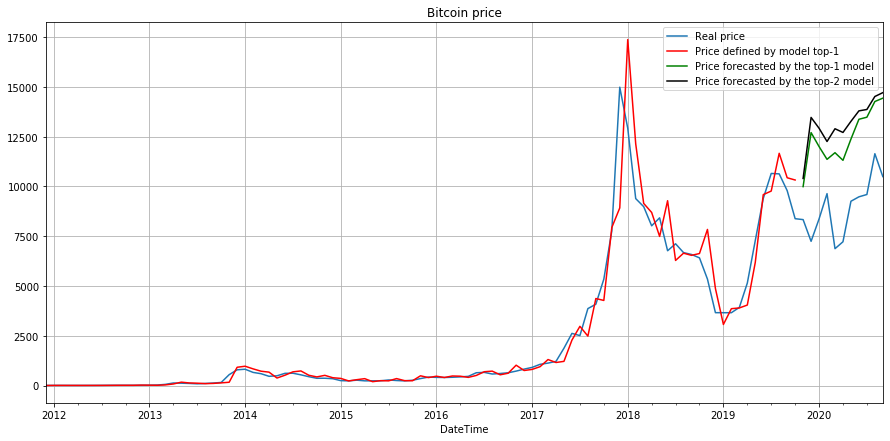

In [211]:
data_month_predict = data_train_month[['Weighted_Price_boxcox']]
prediction_data_month = pd.DataFrame(index=data_test_month.index, columns=['Weighted_Price_boxcox'])
data_month_predict = pd.concat([data_month_predict, prediction_data_month])
data_month_predict['forecast'] = inv_boxcox(best_model.predict(start=data_train_month.shape[0], end=data_train_month.shape[0]+data_test_month.shape[0]), lmbda)
data_month_predict['forecast_2'] = inv_boxcox(best_model_2.predict(start=data_train_month.shape[0], end=data_train_month.shape[0]+data_test_month.shape[0]), lmbda)

plt.figure(figsize=(15,7))
data_month['Weighted_Price'].plot()
data_train_month['model'].plot(color='r')
data_month_predict.forecast.plot(color='g')
data_month_predict.forecast_2.plot(color='black')
plt.title('Bitcoin price')
plt.legend(['Real price', 'Price defined by model top-1', 'Price forecasted by the top-1 model', 'Price forecasted by the top-2 model'])
plt.grid()

## 9. Выводы

1) Видно, что хотя модель и примерно угадывает тренд, однако же разброс с реальными значениями остается достаточно большим.

2) К сожалению, top-2 модель показывает предсказания заметно хуже, чем топ-1.

2) Очевидными минусами модели ARIMA являются:
- Ручной выбор начального приближения для параметров $p, q, P,$ и $Q$.
- Для того, чтобы определить оптимальную модель по критеррию Акаике требуется воспользоваться полным перебором, что является не очень оптимальной стратегией (на 1000 итераций тратится более часа).